# Q-Learning Simple Example using Colab

This example illustrates Q-Learning under 3 different policies:

* The Accountant
* The Gambler
* The Drunkard



The original code may be found in this [github repo](https://github.com/valohai/qlearning-simple).

# Getting Code

1. Download and unzip the folder from HuskyCT
1. Upload the folder to your Google Drive
1. Mount your Drive

<img src="https://www.tutorialspoint.com/google_colab/images/authentication_code.jpg" width="600">

You'll be asked ot login to your Google account. Grant permission, you will receive a code which you'll paste into the authorization code box.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# If you experience a problem, try adding an underscore before mount, i.e. drive._mount('/content/drive')

Navigate to your folder where the code is.

In [2]:
%%capture
%cd /content/drive/MyDrive/MachineLearning_Courses_5820/Colab\ Notebooks/RL/qlearning-simple

In [3]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


You can navigate to your Drive folder on the left.

To edit files, double click, modify and save.

# Code Layout

## Dungeon Simulation

**Rules of the Game**
  - Dungeon 5 tiles long
  - Possible actions are FORWARD and BACKWARD
  - FORWARD is always 1 step, except on last tile it bumps into a wall
  - BACKWARD always takes you back to the start
  - Sometimes a wind flips action to opposite direction

**Unknown to Agent**
* Entering last tile produces +10 reward
* Entering first tile gives you +2 reward
* No reward on other tiles



In [4]:
%pycat dungeon_simulator.py

from enums import *
import random

class DungeonSimulator:
    def __init__(self, length=5, slip=0.1, small=2, large=10):
        self.length = length # Length of the dungeon
        self.slip = slip  # probability of 'slipping' an action
        self.small = small  # payout for BACKWARD action
        self.large = large  # payout at end of chain for FORWARD action
        self.state = 0  # Start at beginning of the dungeon

    def take_action(self, action):
        if random.random() < self.slip:
            action = not action  # agent slipped, reverse action taken
        if action == BACKWARD:  # BACKWARD: go back to the beginning, get small reward
            reward = self.small
            self.state = 0
        elif action == FORWARD:  # FORWARD: go up along the dungeon
            if self.state < self.length - 1:
                self.state += 1
                reward = 0
            else:
                reward = self.large
        return self.state, reward

    def reset(self

## Agent

* The Accountant
  - Greedy, always select the action that has largest reward from estimated Q-table
  - If rewards are equal, choose randomly

In [5]:
%pycat accountant.py

from enums import *
import random

class Accountant:
    def __init__(self):
        # Spreadsheet (Q-table) for rewards accounting
        self.q_table = [[0,0,0,0,0], [0,0,0,0,0]]

    def get_next_action(self, state):
        # Is FORWARD reward is bigger?
        if self.q_table[FORWARD][state] > self.q_table[BACKWARD][state]:
            return FORWARD

        # Is BACKWARD reward is bigger?
        elif self.q_table[BACKWARD][state] > self.q_table[FORWARD][state]:
            return BACKWARD

        # Rewards are equal, take random action
        return FORWARD if random.random() < 0.5 else BACKWARD

    def update(self, old_state, new_state, action, reward):
        self.q_table[action][old_state] += reward


* The Gambler (" $\epsilon$-greedy")
  - Choose optimal action from Q-table
  - With a chance $\epsilon$, select random action
  - If rewards are equal, choose randomly
  
Note: This code has a variation to decay $\epsilon$ during the simulation. It starts high causing the agent to explore and decreases causing the agent to exploit its knowledge of the environment.


In [6]:
%pycat gambler.py

from enums import *
import random

class Gambler:
    def __init__(self, learning_rate=0.1, discount=0.95, exploration_rate=1.0, iterations=10000):
        self.q_table = [[0,0,0,0,0], [0,0,0,0,0]] # Spreadsheet (Q-table) for rewards accounting
        self.learning_rate = learning_rate # How much we appreciate new q-value over current
        self.discount = discount # How much we appreciate future reward over current
        self.exploration_rate = 1.0 # Initial exploration rate
        self.exploration_delta = 1.0 / iterations # Shift from exploration to explotation

    def get_next_action(self, state):
        if random.random() > self.exploration_rate: # Explore (gamble) or exploit (greedy)
            return self.greedy_action(state)
        else:
            return self.random_action()

    def greedy_action(self, state):
        # Is FORWARD reward is bigger?
        if self.q_table[FORWARD][state] > self.q_table[BACKWARD][state]:
            return FORWARD
        # Is BACKWA

* The Drunkard
  - Always take random actions

In [7]:
%pycat drunkard.py

from enums import *
import random

class Drunkard:
    def __init__(self):
        self.q_table = None

    def get_next_action(self, state):
        # Random walk
        return FORWARD if random.random() < 0.5 else BACKWARD

    def update(self, old_state, new_state, action, reward):
        pass # I don't care! I'm drunk!!


## Training

The Dungeon simulation is turn-based:
* Query the agent for next action and pass to simulation
* Get new state and reward and pass them to agent
* Repeat

In [8]:
%pycat train.py

import random
import json
import argparse
import time
from drunkard import Drunkard
from accountant import Accountant
from gambler import Gambler
from dungeon_simulator import DungeonSimulator
import pandas as pd

def main():
    # parse arguments
    parser = argparse.ArgumentParser()
    parser.add_argument('--agent', type=str, default='GAMBLER', help='Which agent to use')
    parser.add_argument('--learning_rate', type=float, default=0.5, help='How quickly the algorithm tries to learn')
    parser.add_argument('--discount', type=float, default=0.98, help='Discount for estimated future action')
    parser.add_argument('--iterations', type=int, default=2000, help='Iteration count')
    parser.add_argument('--seed', type=int, default=42, help='For reproducibility')
    ARGS, unparsed = parser.parse_known_args()

    random.seed(ARGS.seed)

    # select agent
    if ARGS.agent == 'GAMBLER':
        agent = Gambler(learning_rate=ARGS.learning_rate, discount=ARGS.discount, iterations=ARGS

In [15]:
!python train.py --agent=ACCOUNTANT --iterations=1000

{"step": 0, "performance": 0.0, "total_reward": 0}
{"step": 250, "performance": 1.624, "total_reward": 406}
{"step": 500, "performance": 1.672, "total_reward": 824}
{"step": 750, "performance": 1.736, "total_reward": 1258}


Final Q-table
       0   1    2  3  4
0     0  18    0  0  0
1  1530   0  134  8  0


In [16]:
!python train.py --agent=GAMBLER --iterations=1000

{"step": 0, "performance": 0.0, "total_reward": 0}
{"step": 250, "performance": 1.368, "total_reward": 342}
{"step": 500, "performance": 1.624, "total_reward": 748}
{"step": 750, "performance": 1.608, "total_reward": 1150}


Final Q-table
            0          1          2          3          4
0  81.560705  76.896847  48.919734  60.762169  76.279216
1  88.528399  87.810485  83.161774  57.920703  59.655093


In [17]:
!python train.py --agent=DRUNKARD --iterations=1000

{"step": 0, "performance": 0.0, "total_reward": 0}
{"step": 250, "performance": 1.344, "total_reward": 336}
{"step": 500, "performance": 1.352, "total_reward": 674}
{"step": 750, "performance": 1.512, "total_reward": 1052}


Final Q-table
 Empty DataFrame
Columns: []
Index: []


Note: no Q-table for Drunkard as actions are always random.

In [20]:
import pandas as pd
gambler = pd.read_csv('simple_RL_GAMBLER.csv')
accountant = pd.read_csv('simple_RL_ACCOUNTANT.csv')
drunkard = pd.read_csv('simple_RL_DRUNKARD.csv')

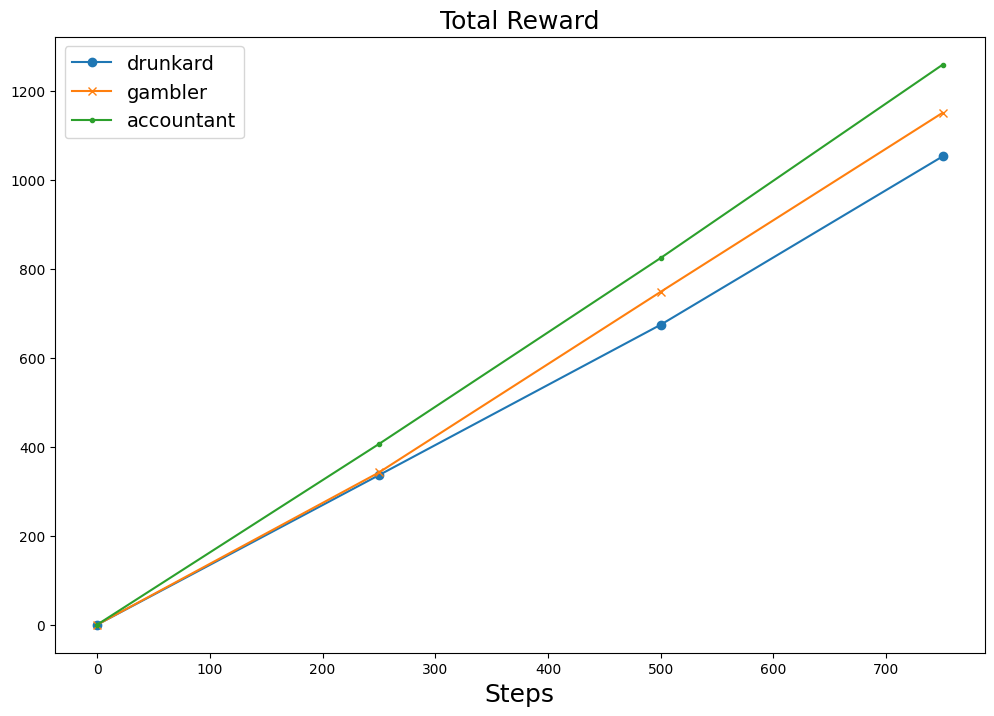

In [21]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12,8))
plt.plot(drunkard['Step'], drunkard['Total Reward'], label='drunkard', marker='o')
plt.plot(gambler['Step'], gambler['Total Reward'], label='gambler',marker='x')
plt.plot(accountant['Step'], accountant['Total Reward'], label='accountant',marker='.')
plt.xlabel('Steps', fontsize=18)
plt.title('Total Reward', fontsize=18)
plt.legend(prop={'size': 14})
plt.show()

* The drunkard
 - Random actions produce close to straight line, indicating no learning is taking place

* The accountant
 - Less variation than drunkard as it exploits BACKWARD action
 - More reward than drunkard

* The gambler
 - Q-learning is happening with the gambler! 

In [14]:
# To unmount 
#drive.flush_and_unmount()